# Sentimental Analysis

### [2024.01.14] 이상혁

### 개요
- [출처] [IMDB 리뷰 감성 분류하기 - 위키독스](https://wikidocs.net/24586 '구글')
- 감성 분류를 연습하기 위해 자주 사용하는 영어 데이터로, 영화 사이트 IMDB의 리뷰 데이터
- 스탠포드 대학교에서 2011년에 낸 논문에서 이 데이터를 소개하였으며, 당시 논문에서는 이 데이터를 훈련 데이터와 테스트 데이터를 50:50대 비율로 분할하여 88.89%의 정확도를 얻었다고 소개하고 있음
- 스탠포드 대학 연구팀에서 작성한 논문은 다음 링크에서 확인할 수 있다. [Learning Word Vectors for Sentiment Analysis](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf)
- 케라스에서 imdb.load_data() 함수를 통해 바로 다운로드 할 수 있도록 지원하고 있음

### 0. GPU Configuration

💻빠른 연산을 위해 Tensorflow에서 **GPU**를 사용할 수 있도록 설정해준다.

In [2]:
# gpu 사용 가능 여부 확인
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = '0' # 0번째 디바이스 사용
gpus = tf.config.experimental.list_physical_devices('GPU') # GPU 장치 목록 반환

if gpus:
    try: 
        tf.config.experimental.set_memory_growth(gpus[0], True) # gpu가 있다면 활성화 시킨다.
    except RuntimeError as e: 
        print(e)

GPU 설정이 마무리 되었다. 이제 본격적으로 데이터부터 불러오자.

### 1. Libraries

In [4]:
import warnings
warnings.filterwarnings('ignore')

import os
import sys
import time
import random
import datetime

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.datasets import imdb

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Embedding, LSTM, Dropout, Conv1D, GlobalMaxPooling1D, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [5]:
# 시드 설정
SEED = 114

random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### 2. Load Data

데이터를 불러오는 방법은 imdb.load_data()라는 메서드를 사용하면 되기 때문에 간단하다. 하지만 별도 split 기능을 제공하지 않고, 기본적으로 설정된 5:5 비율을 사용해여 한다.😥

In [5]:
# 훈련용, 테스트용 데이터 불러오기
(X_train, y_train), (X_test, y_test) = imdb.load_data()

### 3. EDA

In [11]:
print('훈련용 리뷰 개수 : {}'.format(len(X_train)))
print('테스트용 리뷰 개수 : {}'.format(len(X_test)))
num_classes = len(set(y_train))
print('카테고리 : {}'.format(num_classes))

훈련용 리뷰 개수 : 25000
테스트용 리뷰 개수 : 25000
카테고리 : 2


In [13]:
# 카테고리 확인
print(set(y_train))

{0, 1}


- 감정 분석이기 때문에 0은 부정, 1은 긍정을 나타내는 이진 분류 문제가 된다.

25,000 개의 데이터 중에 첫번째 데이터의 구성과 레이블을 확인해보자.

In [14]:
print('첫번째 훈련용 리뷰 :',X_train[0])
print('첫번째 훈련용 리뷰의 레이블 :',y_train[0])

첫번째 훈련용 리뷰 : [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 22665, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 21631, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 19193, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 10311, 8, 4, 107, 117, 5952, 15, 256, 4, 31050, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 12118, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]
첫번째 훈련용 리뷰의 레이블 : 1


- 데이터가 모두 정수 인코딩이 되어있다.
- 별도 임베딩 과정은 필요하지 않아서 좋다.👍
- 실제로 IMDB 리뷰 데이터는 전체 데이터에서 각 단어들의 등장 빈도에 따라서 인덱스를 부여했다고 한다.

각 리뷰 데이터마다 길이가 다를 것 같다. 각 리뷰 데이터 길이의 분포를 한번 시각화해보자.

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


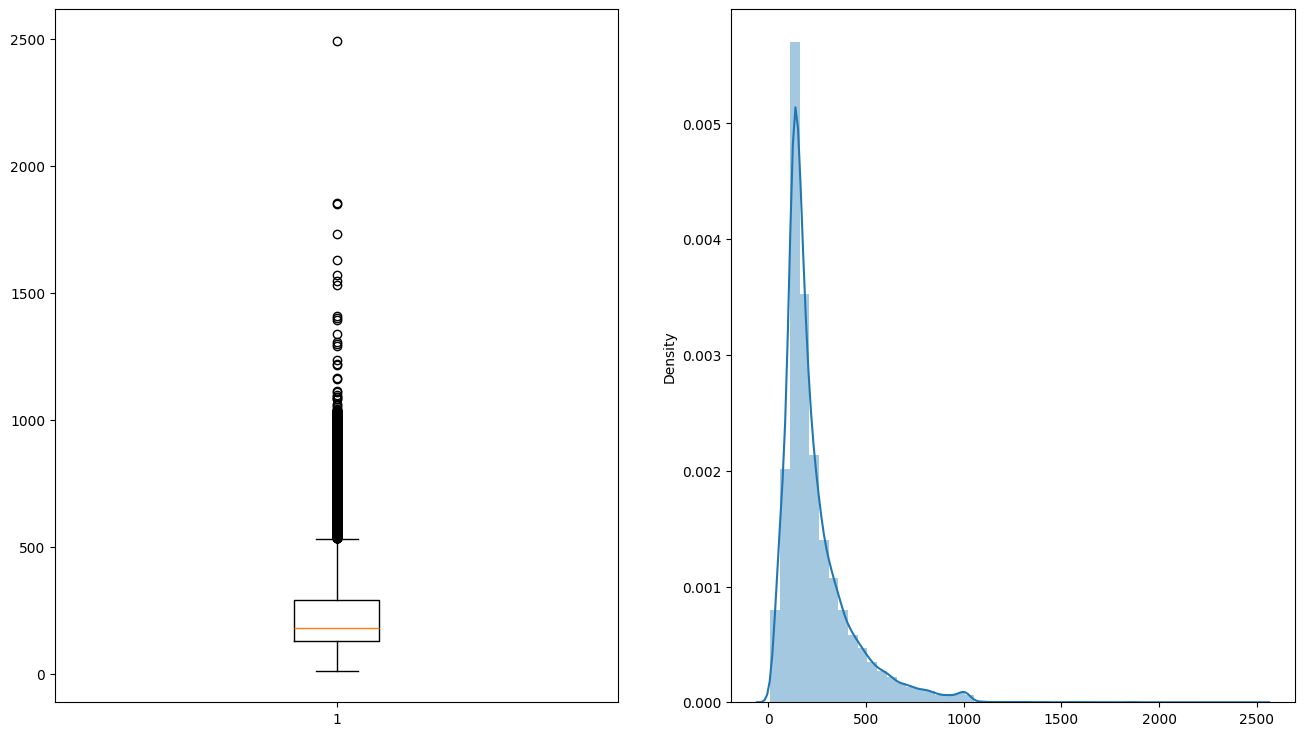

In [24]:
length = []
for data in X_train:
    length.append(len(data))

print('리뷰의 최대 길이 : {}'.format(np.max(length)))
print('리뷰의 평균 길이 : {}'.format(np.mean(length)))

plt.figure(figsize=(16, 9))
plt.subplot(1, 2, 1)
plt.boxplot(length)

plt.subplot(1, 2, 2)
sns.distplot(length, kde=True, rug=False)
plt.show()

- 분포가 왼쪽으로 치우쳐져 있다.
- 평균적으로 230 단어 내외의 리뷰가 많다고 할 수 있다.

이번에는 타깃이 y에 대해서 분포를 그려 살펴보자(⚠ 이때 y_test가 아닌 y_train의 특징을 살펴봐야 Data Leakage가 발생하지 않는다.)

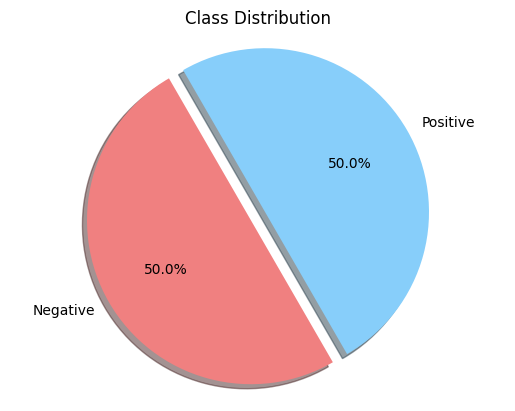

In [29]:
# 클래스 별 개수 계산
count_0 = np.sum(y_train == 0)
count_1 = np.sum(y_train == 1)

# 파이차트 그리기
labels = ['Negative', 'Positive']
sizes = [count_0, count_1]
colors = ['lightcoral', 'lightskyblue']
explode = (0, 0.1)  # 긍정 클래스를 강조하기 위해서 간격 설정

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=120)
plt.axis('equal')  # 원이 눌리지 않도록 설정
plt.title('Class Distribution')
plt.show()

- 데이터를 제공 받을 때 train/test가 5:5로 분할되었다고 했는데, 타깃 값의 긍정/부정의 분포도 정확하게 5:5로 나온다.

이번에는 X_train의 각 리뷰 데이터의 숫자들이 어떤 단어였는지 살펴보자. <br>
imdb.get_word_index() 메서드를 사용하면 된다.

In [29]:
word_to_index = imdb.get_word_index()
index_to_word = {}
for key, value in word_to_index.items():
    index_to_word[value+3] = key # 실제 단어를 알기 위해서는 +3을 해야 한다고 함

In [31]:
print('빈도수 상위 1등 단어 : {}'.format(index_to_word[4]))

빈도수 상위 1등 단어 : the


In [32]:
print('빈도수 상위 3938등 단어 : {}'.format(index_to_word[250]))

빈도수 상위 3938등 단어 : girl


그럼 X_train의 첫번째 리뷰는 원래 어땠는지 확인해보자.

In [34]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index] = token

print(' '.join([index_to_word[index] for index in X_train[0]]))
print('')
print('이 리뷰의 레이블 : {}'.format(y_train[0]))

<sos> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shoul

### 4. Modelling

#### 4-1. GRU

모델링을 진행하기에 앞서서 약간의 전처리를 거쳐보자.

In [6]:
vocab_size = 10000
max_len = 500

In [7]:
# 단어 집합의 크기를 10,000으로 제한
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=vocab_size)

In [8]:
# 리뷰 길이 500으로 제한 후 패딩
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

이제 본격적으로 모델을 설계해보자.
- 임베딩 벡터의 차원은 100, 은닉 상태의 크기는 128(하이퍼파라미터)
- Base model은 다대일 구조의 GRU
- 출력층 활성화 함수로는 시그모이드 함수(이진 분류이기 때문에)
- 손실 함수로 크로스 엔트로피 함수
- 배치 크기는 64이며, 15 에포크를 수행(하이퍼파라미터)

기본적인 구조는 위와 같고, 이번에는 과적합 방지를 위한 설정을 추가하자.
- 조기종료(EarlyStopping)를 사용해서 **검증 데이터 손실(val_loss)**을 기준으로 4 epoch 이상 손실이 개선되지 않으면 학습을 종료
- ModelCheckpoint를 사용하여 **검증 데이터의 정확도(val_acc)**가 이전보다 좋아질 경우에만 모델을 저장
- 이때 검증 데이터를 별도로 분리할 필요 없이, validation_split=0.2을 사용하여 훈련 데이터의 20%를 검증 데이터로 분리해서 사용(sklearn의 train_test_split을 사용해도 된다.)

In [9]:
# 임베딩, 은닉층 하이퍼파라미터
embedding_dim = 100
hidden_units = 128

In [10]:
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim)) # 임베딩 계층(10,000개의 어휘를 100개로 임베딩)
model.add(GRU(hidden_units)) # GRU 계층
model.add(Dense(1, activation='sigmoid'))

In [11]:
# 과적합 방지를 위한 조기 종료와 체크포인트
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('GRU_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [12]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         1000000   
                                                                 
 gru (GRU)                   (None, 128)               88320     
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,088,449
Trainable params: 1,088,449
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.4938 - acc: 0.7610
Epoch 1: val_acc improved from -inf to 0.82540, saving model to GRU_model.h5
313/313 [==============================] - 35s 93ms/step - loss: 0.4938 - acc: 0.7610 - val_loss: 0.4166 - val_acc: 0.8254
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.3168 - acc: 0.8735
Epoch 2: val_acc improved from 0.82540 to 0.85120, saving model to GRU_model.h5
313/313 [==============================] - 28s 89ms/step - loss: 0.3168 - acc: 0.8735 - val_loss: 0.3427 - val_acc: 0.8512
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.2548 - acc: 0.9039
Epoch 3: val_acc improved from 0.85120 to 0.88840, saving model to GRU_model.h5
313/313 [==============================] - 28s 89ms/step - loss: 0.2548 - acc: 0.9039 - val_loss: 0.2825 - val_acc: 0.8884
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.2008 - acc: 0.9265
Epoch 4: val_acc improved from

- epoch 9에서 조기종료 됐고, epoch 5까지의 모델이 체크포인트에 저장되었다. 
- 체크포인트 저장은 이번에 처음 써보는데, 평가에 있어서 가장 좋은 모델을 사용할 수 있기 때문에 유용할 것 같다.

학습 추이를 시각화해보자.

In [26]:
# 학습 과정 시각화 함수
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['acc'], label='Train Accuracy')
    plt.plot(history.history['val_acc'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

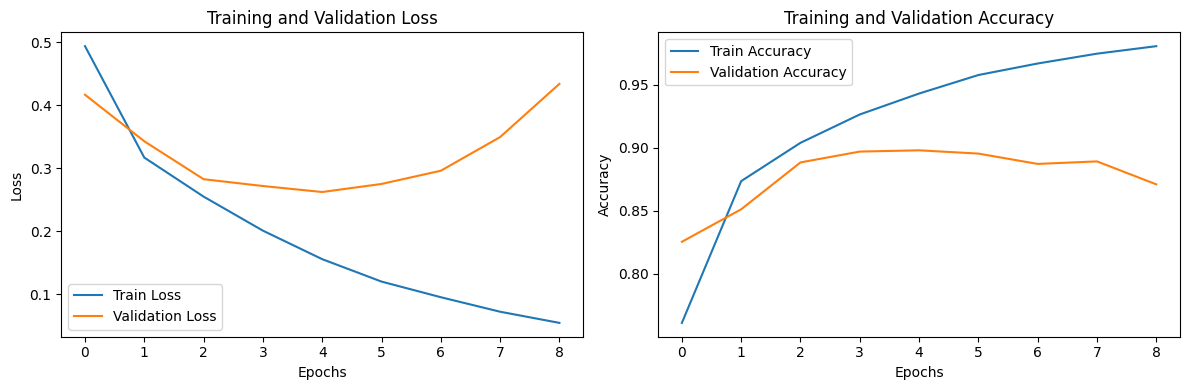

In [16]:
plot_training_history(history)

- Train과 Validation의 간극이 점점 벌어지기는 하지만, Accuracy가 0.85 이상에서 유지되고 있었다는 점에서 성능은 좋은것 같다.

훈련 과정에서 검증 데이터의 정확도가 가장 높았을 때 저장된 모델인 'GRU_model.h5'를 로드해서 Test해보자.

In [17]:
loaded_model = load_model('GRU_model.h5')
loaded_model.evaluate(X_test, y_test)[1] # 정확도만 확인

782/782 [==============================] - 20s 25ms/step - loss: 0.2927 - acc: 0.8844


0.8844000101089478

- 88.44%로 모델 예측 성능이 괜찮은 것 같다.

#### 4-2. LSTM

이번에는 단순한 LSTM 계층을 사용해서 신경망을 만들자. GRU와 LSTM 모두 게이트를 추가하여 RNN을 개선한 계층들이다.

In [51]:
# 임베딩, 은닉층 하이퍼파라미터
embedding_dim = 100
hidden_units = 128

In [54]:
model2 = Sequential()
model2.add(Embedding(vocab_size, embedding_dim))
model2.add(LSTM(hidden_units)) # 이 부분을 제외하고 모든 코드가 동일
model2.add(Dense(1, activation='sigmoid'))

In [60]:
# 과적합 방지를 위한 조기 종료와 체크포인트
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('LSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [61]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [62]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 100)         1000000   
                                                                 
 lstm (LSTM)                 (None, 128)               117248    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,117,377
Trainable params: 1,117,377
Non-trainable params: 0
_________________________________________________________________


- LSTM 계층이 GRU 계층보다 추정해야 할 파라미터가 더 많다.

In [63]:
history2 = model2.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15


313/313 [==============================] - ETA: 0s - loss: 0.1265 - acc: 0.9560
Epoch 1: val_acc improved from -inf to 0.87600, saving model to LSTM_model.h5
313/313 [==============================] - 34s 100ms/step - loss: 0.1265 - acc: 0.9560 - val_loss: 0.4020 - val_acc: 0.8760
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.1071 - acc: 0.9625
Epoch 2: val_acc did not improve from 0.87600
313/313 [==============================] - 31s 99ms/step - loss: 0.1071 - acc: 0.9625 - val_loss: 0.3611 - val_acc: 0.8750
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.0910 - acc: 0.9681
Epoch 3: val_acc did not improve from 0.87600
313/313 [==============================] - 29s 93ms/step - loss: 0.0910 - acc: 0.9681 - val_loss: 0.4396 - val_acc: 0.8522
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.0745 - acc: 0.9736
Epoch 4: val_acc improved from 0.87600 to 0.88040, saving model to LSTM_model.h5
313/313 [=================

- epoch 5에서 조기종료 되었고, epoch 4의 모델이 가장 좋은 val_acc를 기록해 체크포인트에 저장되었다.

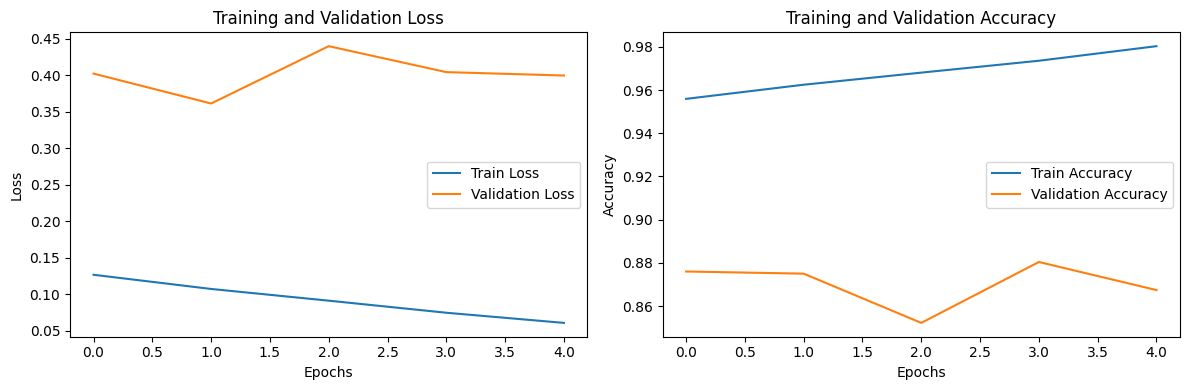

In [64]:
plot_training_history(history2)

- 안타깝게도 Training 시에 과적합이 심하게 발생하는 것 같다. 그래서 조기 종료도 빠르게 된 것 같다.
- 그래도 검증 데이터셋에서 정확도가 86% 이상을 보이는 것만 봐서는 성능은 좋은 것 같다.

In [65]:
loaded_model = load_model('LSTM_model.h5')
loaded_model.evaluate(X_test, y_test)[1] # 정확도만 확인

782/782 [==============================] - 23s 28ms/step - loss: 0.4680 - acc: 0.8648


0.8647599816322327

- 86.5% 정도로 모델 성능은 GRU보다 살짝 낮지만 비슷하다. 별다른 설정 없이 간단하게 층을 쌓았는데 성능이 나쁘지 않은 것 같다.

#### 4-3. 1D CNN

Conv2D를 사용하면 이미지 처리를 할 수 있었다. 자연어는 1차원의 데이터이므로 이번에는 Conv2D를 사용해보자.

In [11]:
model3 = Sequential()
model3.add(Embedding(vocab_size, 256))
model3.add(Dropout(0.3))
model3.add(Conv1D(256, 3, padding='valid', activation='relu'))
model3.add(GlobalMaxPooling1D())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(1, activation='sigmoid'))

1. 임베딩 층
- 임베딩 계층은 단어를 밀집 벡터(분산 표현) 만들어준다. 입력 차원이 vocab_size일 때, 출력 차원이 256이 된다.
2. 드롭아웃 층
- 과적합을 방지하기 위한 정규화 기법이다.
- 훈련 과정에서 임의의 뉴런 30%가 무시된다.
3. Conv1D 층
- 크기 3의 커널을 사용하여 256개의 필터를 가지고 있다.
- 이때 패딩은 'valid'로 설정되어 입력에 패딩이 추가되지 않는다.
- 활성화 함수로는 ReLU를 사용한다.
4. GlobalMaxPooling1D 층
- 입력의 차원을 줄이고 필요한 정보만 남긴다.
5. Dense 층
- 128개의 뉴런을 사용
- 활성화 함수는 ReLU
6. 드롭아웃 층
- 훈련 과정에서 임의의 뉴런 50%가 무시된다.
7. Dense 층
- 1개의 뉴런
- 시그모이드 함수를 사용해서 이진 분류 결과 출력

In [20]:
# 과적합 방지를 위한 조기 종료와 체크포인트
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('CNN_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [21]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])

In [22]:
model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 256)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 256)         196864    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                      

- 이전 모델들보다 추정해야 할 파라미터 개수가 2배로 늘었났다.

In [23]:
history3 = model3.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.4685 - acc: 0.7618
Epoch 1: val_acc improved from -inf to 0.86240, saving model to CNN_model.h5
313/313 [==============================] - 47s 145ms/step - loss: 0.4685 - acc: 0.7618 - val_loss: 0.3237 - val_acc: 0.8624
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.2672 - acc: 0.8908
Epoch 2: val_acc improved from 0.86240 to 0.88460, saving model to CNN_model.h5
313/313 [==============================] - 40s 128ms/step - loss: 0.2672 - acc: 0.8908 - val_loss: 0.2735 - val_acc: 0.8846
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.1865 - acc: 0.9276
Epoch 3: val_acc improved from 0.88460 to 0.89180, saving model to CNN_model.h5
313/313 [==============================] - 41s 130ms/step - loss: 0.1865 - acc: 0.9276 - val_loss: 0.2733 - val_acc: 0.8918
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.1301 - acc: 0.9531
Epoch 4: val_acc improved f

- Epoch 7에서 조기종료됐다. Epoch 5의 모델을 체크포인트에 저장되었다.

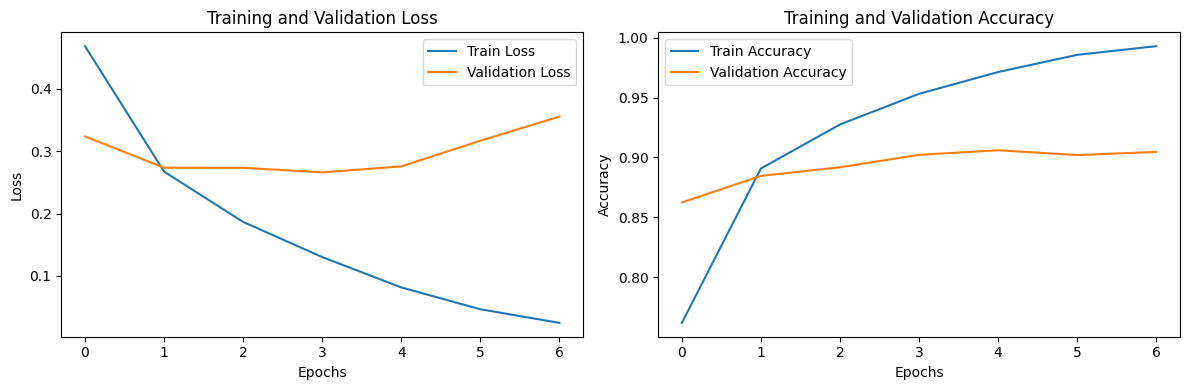

In [24]:
plot_training_history(history3)

- 정확도가 그래도 85%-90% 사이에서 유지되었다. 분류 정확도가 괜찮다고 할 수 있다.

In [25]:
loaded_model = load_model('CNN_model.h5')
loaded_model.evaluate(X_test, y_test)[1] # 정확도만 확인

782/782 [==============================] - 16s 20ms/step - loss: 0.2876 - acc: 0.8992


0.8991600275039673

- Test 정확도 결과는 89.91%로 3가지 모델 중 가장 성능이 좋다.

#### 4-4. Bidirectional LSTM

이번에는 LSTM의 변형인 양방향 LSTM을 사용해보자.

In [17]:
model4 = Sequential()
model4.add(Embedding(vocab_size, embedding_dim))
model4.add(Bidirectional(LSTM(128)))
model4.add(Dropout(0.3))
model4.add(Dense(1, activation='sigmoid'))

In [21]:
# 과적합 방지를 위한 조기 종료와 체크포인트
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('BiLSTM_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [22]:
model4.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [23]:
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 100)         1000000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              234496    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 257       
                                                                 
Total params: 1,234,753
Trainable params: 1,234,753
Non-trainable params: 0
_________________________________________________________________


In [24]:
history4 = model4.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

Epoch 1/15
313/313 [==============================] - ETA: 0s - loss: 0.4594 - acc: 0.7710
Epoch 1: val_acc improved from -inf to 0.85460, saving model to BiLSTM_model.h5
313/313 [==============================] - 69s 204ms/step - loss: 0.4594 - acc: 0.7710 - val_loss: 0.3517 - val_acc: 0.8546
Epoch 2/15
313/313 [==============================] - ETA: 0s - loss: 0.2670 - acc: 0.8957
Epoch 2: val_acc improved from 0.85460 to 0.86000, saving model to BiLSTM_model.h5
313/313 [==============================] - 62s 199ms/step - loss: 0.2670 - acc: 0.8957 - val_loss: 0.3326 - val_acc: 0.8600
Epoch 3/15
313/313 [==============================] - ETA: 0s - loss: 0.1901 - acc: 0.9298
Epoch 3: val_acc improved from 0.86000 to 0.87400, saving model to BiLSTM_model.h5
313/313 [==============================] - 62s 198ms/step - loss: 0.1901 - acc: 0.9298 - val_loss: 0.3462 - val_acc: 0.8740
Epoch 4/15
313/313 [==============================] - ETA: 0s - loss: 0.1454 - acc: 0.9477
Epoch 4: val_acc d

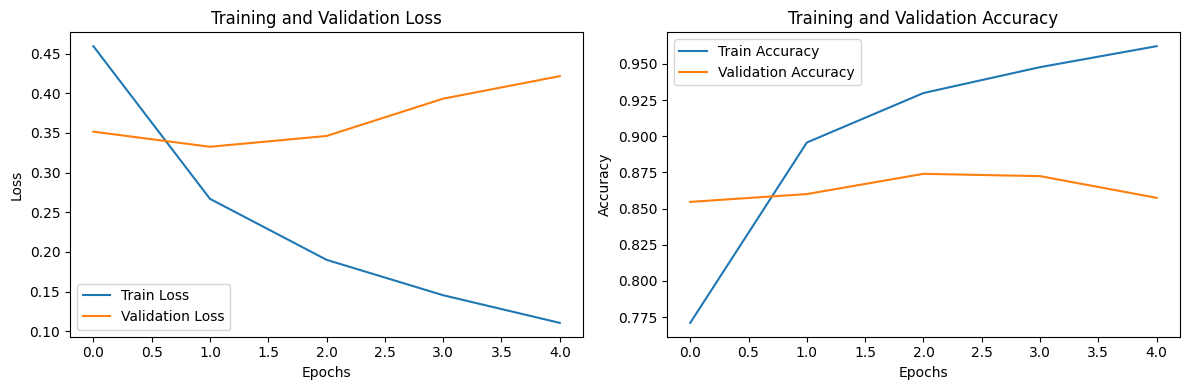

In [27]:
plot_training_history(history4)

- 이번 모델의 정확도는 약 85%에서 왔다갔다 하고 있다. 이전 모델들의 성능보다는 약간 떨어지는 것 같다.

In [28]:
loaded_model = load_model('BiLSTM_model.h5')
loaded_model.evaluate(X_test, y_test)[1] # 정확도만 확인

782/782 [==============================] - 41s 51ms/step - loss: 0.3613 - acc: 0.8671


0.8670799732208252

- 정확도는 약 86% 정도 나온다.

종합해서 살펴보면 Test 정확도 기준 모델의 결과는 👍CNN(89%) > GRU(86%) = BiLSTM(86%) > LSTM(84%)이다. <br>
성능은 모두 비슷비슷한 것 같다.

### 5. Conclusion

이제 성능이 가장 좋았던 모델을 바탕으로 실제 후기의 긍/부정을 예측해보자.

In [32]:
def sentiment_predict(new_sentence):
  # 알파벳과 숫자를 제외하고 모두 제거 및 알파벳 소문자화
  new_sentence = re.sub('[^0-9a-zA-Z ]', '', new_sentence).lower()
  encoded = []

  # 띄어쓰기 단위 토큰화 후 정수 인코딩
  for word in new_sentence.split():
    try :
      # 단어 집합의 크기를 10,000으로 제한.
      if word_to_index[word] <= 10000:
        encoded.append(word_to_index[word]+3)
      else:
      # 10,000 이상의 숫자는 <unk> 토큰으로 변환.
        encoded.append(2)
    # 단어 집합에 없는 단어는 <unk> 토큰으로 변환.
    except KeyError:
      encoded.append(2)

  pad_sequence = pad_sequences([encoded], maxlen=max_len)
  loaded_model = load_model('CNN_model.h5')
  score = float(loaded_model.predict(pad_sequence)) # 예측

  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [33]:
# 실제 IMDB 사이트의 영화 블랙팬서의 1점 리뷰
test_input = "This movie was just way too overrated. The fighting was not professional and in slow motion. I was expecting more from a 200 million budget movie. The little sister of T.Challa was just trying too hard to be funny. The story was really dumb as well. Don't watch this movie if you are going because others say its great unless you are a Black Panther fan or Marvels fan."

sentiment_predict(test_input)

1/1 [==============================] - 0s 490ms/step
99.88% 확률로 부정 리뷰입니다.


In [34]:
# 실제 IMDB 사이트의 영화 어벤져스의 10점 리뷰
test_input = " I was lucky enough to be included in the group to see the advanced screening in Melbourne on the 15th of April, 2012. And, firstly, I need to say a big thank-you to Disney and Marvel Studios. \
Now, the film... how can I even begin to explain how I feel about this film? It is, as the title of this review says a 'comic book triumph'. I went into the film with very, very high expectations and I was not disappointed. \
Seeing Joss Whedon's direction and envisioning of the film come to life on the big screen is perfect. The script is amazingly detailed and laced with sharp wit a humor. The special effects are literally mind-blowing and the action scenes are both hard-hitting and beautifully choreographed."

sentiment_predict(test_input)

1/1 [==============================] - 0s 68ms/step
99.67% 확률로 긍정 리뷰입니다.


In [35]:
# 실제 IMDB 사이트의 영화 블랙팬서 2의 5점 리뷰
test_input = "Enough has been said by other reviewers about the film's overall weaknesses - it's overlong, meandering and drags in many places. Instead, I want to focus on a question no one else seems to be asking: what is up with these Wakandans? I was a definite fan of the first movie, but as the sequel progressed, I found myself more and more annoyed (and irritated) by the film's semi-religious Wakandaphilia. Frankly, the constant self-adulation and smug sense of exceptionalism displayed by every Wakandan character really started to grate. After a while, what I'm sure the film-makers see as a message of empowerment starts to sound a lot like fascistic aggrandizement. If this degree of messianic self-love were displayed by characters in any other (real) country, it would be dismissed as overblown nationalism. Let's not forget, as the film itself points out, Wakanda is a superpower - possibly the most powerful nation on earth, thanks to its stocks of 'vibranium' - so it's difficult to swallow the idea that they are also somehow persecuted victims. Add to this the fact that they jealously try to preserve their monopoly of this most valuable resource, and its associated technology, and its hard not to see Wakanda as just another arrogant and self-interested power. Indeed, after a while, my sympathies shifted much more to the rival Talocans, who with some justification came to see Wakanda as more of a threat than an ally. Maybe the next movie could be called Talocan Forever, and show their side of the story instead."

sentiment_predict(test_input)

1/1 [==============================] - 0s 58ms/step
71.79% 확률로 부정 리뷰입니다.


- 영화의 포커스가 주인공이 아니라 악당인 것 같다라는 내용의 리뷰여서 눈에 띄는 부정 리뷰는 아니지만 그래도 부정적인 리뷰라고 잘 예측한 것 같다. 일부러 애매하게 별 5점짜리를 가져와봤는데 확실히 예측 확률은 떨어진다. 그래도 이 정도면 잘 예측한 것 같다.